# Module Imports

In [1]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import textwrap
import umap.plot

from umap import UMAP
from sklearn.cluster import HDBSCAN
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize

/Users/taylorbolt/opt/miniconda3/envs/brain/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/taylorbolt/opt/miniconda3/envs/brain/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/taylorbolt/opt/miniconda3/envs/brain/lib/python

# 1. Load Phrases and Semantic Embeddings

In [2]:
embed = pickle.load(open('data/embedding/phrase_embeddings.pkl', 'rb'))
embed = [e for e in embed if isinstance(e[2], np.ndarray)]
embed_array = np.vstack([e[2] for e in embed])
embed_norm = normalize(embed_array)

# 2. UMAP Embedding of Phrases

In [3]:
umap_fit = UMAP(
    n_neighbors=15,
    min_dist=0,
    n_components=2,
    metric='cosine',
    random_state=0
)
proj = umap_fit.fit_transform(embed_norm)

# 3. HDBSCAN Clustering of Phrases

In [4]:
hdbscan = HDBSCAN(min_cluster_size = 50, min_samples=40,
                  store_centers='medoid')
hdbscan.fit(proj)

HDBSCAN(min_cluster_size=50, min_samples=40, store_centers='medoid')

# 4. Visualize Results

## 4.1 Visualize UMAP Embedding Space

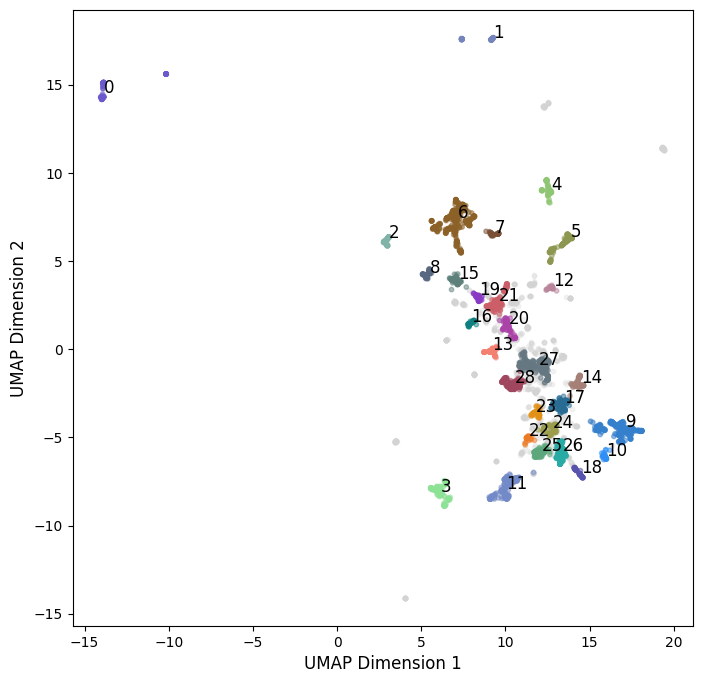

In [5]:
# get unique cluster indices
c_labels = np.sort(np.unique(hdbscan.labels_))
n_c = len(c_labels)

# create a custom segmented colormap
cmap = mpl.colors.LinearSegmentedColormap.from_list("", 
    ["slateblue", "lightgreen", "saddlebrown", "dodgerblue",  
     "salmon", "teal",  "darkorchid", "darkorange", 
     "lightseagreen", "crimson"]
)

# define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
cmap = cmap.from_list('cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.linspace(0,n_c,n_c+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(8,8))

# plot noise points as light gray
c_idx_noise = np.where(hdbscan.labels_ == -1)[0]
c_idx_noise_labels = hdbscan.labels_[c_idx_noise]
proj_c_noise = proj[c_idx_noise,:]
scat = ax.scatter(proj_c_noise[:,0], proj_c_noise[:,1], alpha=0.25,
                  color='lightgray', s=10)

# plot cluster points
c_idx = np.where(hdbscan.labels_ != -1)[0]
c_idx_labels = hdbscan.labels_[c_idx]
proj_c = proj[c_idx,:]
scat = ax.scatter(proj_c[:,0], proj_c[:,1], alpha=0.5, c=c_idx_labels,
                  cmap=cmap, norm=norm, s=10)


# place cluster label at cluster mediod position
for i in range(hdbscan.medoids_.shape[0]):
    medoid_idx = hdbscan.medoids_[i,:]
    ax.text(medoid_idx[0]+0.1, medoid_idx[1]+0.1, i, fontsize=12)

ax.set_xlabel('UMAP Dimension 1', fontsize=12)
ax.set_ylabel('UMAP Dimension 2', fontsize=12)


# ax.legend()
plt.savefig('umap.png', transparent=True)

## 4.2 Print phrases belonging to each cluster

In [112]:
clus = 29

embed_text = [e[1] for e in embed]
clus_idx = np.where(hdbscan.labels_ == clus)[0]
for i in clus_idx:
    print(embed_text[i])

## 4.3 Supplementary Table 1 - Journal by Cluster Counts

In [115]:
# load in all article metadata
articles = json.load(open('data/misc/matched_articles.json', 'rb'))
# json is a list of dictionaries, re-index each article with doi to create global dictionary
articles = {a['doi']: a for a in articles}
# pull the doi from each expression
doi_list = [e[0] for e in embed]


In [124]:
# create Pandas dataframe for easy manipulation
clus_df = pd.DataFrame({
    'doi': doi_list,
    'journal': [articles[d]['journal'] for d in doi_list],
    'clus': hdbscan.labels_,
    'year': [articles[d]['publication_year'] if 'publication_year' in articles[d] 
             else np.NaN 
             for d in doi_list]
})

# filter out journals w/ infrequent articles (< 20)
clus_df['journal_n'] = clus_df.groupby('journal')['doi'].transform('count')
clus_df =  clus_df.loc[clus_df.journal_n >= 20].copy()

# define cluster label descriptions 
# these labels will be non-applicable if cluster params or random seed is changed
clus_labels = {
    0: 'cholesterol-rich',
    2: 'lipid rich',
    3: 'most-complex-organ',
    4: 'metastasis',
    5: 'immune-priveleged',
    6: 'energy-demanding',
    7: 'high-vascularization',
    8: 'oxygen-demanding',
    9: 'complex-network',
    10: 'complex-network',
    11: 'heterogenous-organ',
    13: 'steroidogenic',
    14: 'prediction-machine',
    15: 'oxidative-stress',
    16: 'stress-adaptation',
    17: 'information-processor',
    18: 'non linear-system',
    19: 'toxicity',
    22: 'complex-system',
    23: 'adaptive-plastic',
    24: 'integrated-system',
    25: 'complex-system',
    26: 'complex-dynamic',
    28: 'control-system'
}

# filter to selected clusters
selected_clus = list(clus_labels.keys())
clus_df = clus_df.loc[clus_df.clus.isin(selected_clus)].copy()

clus_df['clus_label'] = clus_df.clus.replace(clus_labels)

# shorten these journal names
j_short = {
    'International Journal of Environmental Research and Public Health': \
    'I.J. of Environmental Research and Public Health',
    'Evidence-based Complementary and Alternative Medicine : eCAM': 'eCAM'
}
clus_df['journal'] = clus_df.journal.replace(j_short)

# calculate crosstab
cj_ct = pd.crosstab(clus_df['journal'], clus_df['clus_label'])

In [130]:
clus_count = {clus_labels[c]: 0 for c in clus_labels}
for i in np.unique(hdbscan.labels_):
    if i in clus_labels:
        clus_count[clus_labels[i]] += (hdbscan.labels_ == i).sum()
clus_count

{'cholesterol-rich': 83,
 'lipid rich': 71,
 'most-complex-organ': 155,
 'metastasis': 112,
 'immune-priveleged': 157,
 'energy-demanding': 426,
 'high-vascularization': 51,
 'oxygen-demanding': 67,
 'complex-network': 412,
 'heterogenous-organ': 248,
 'steroidogenic': 64,
 'prediction-machine': 86,
 'oxidative-stress': 99,
 'stress-adaptation': 54,
 'information-processor': 111,
 'non linear-system': 66,
 'toxicity': 61,
 'complex-system': 150,
 'adaptive-plastic': 59,
 'integrated-system': 58,
 'complex-dynamic': 133,
 'control-system': 160}

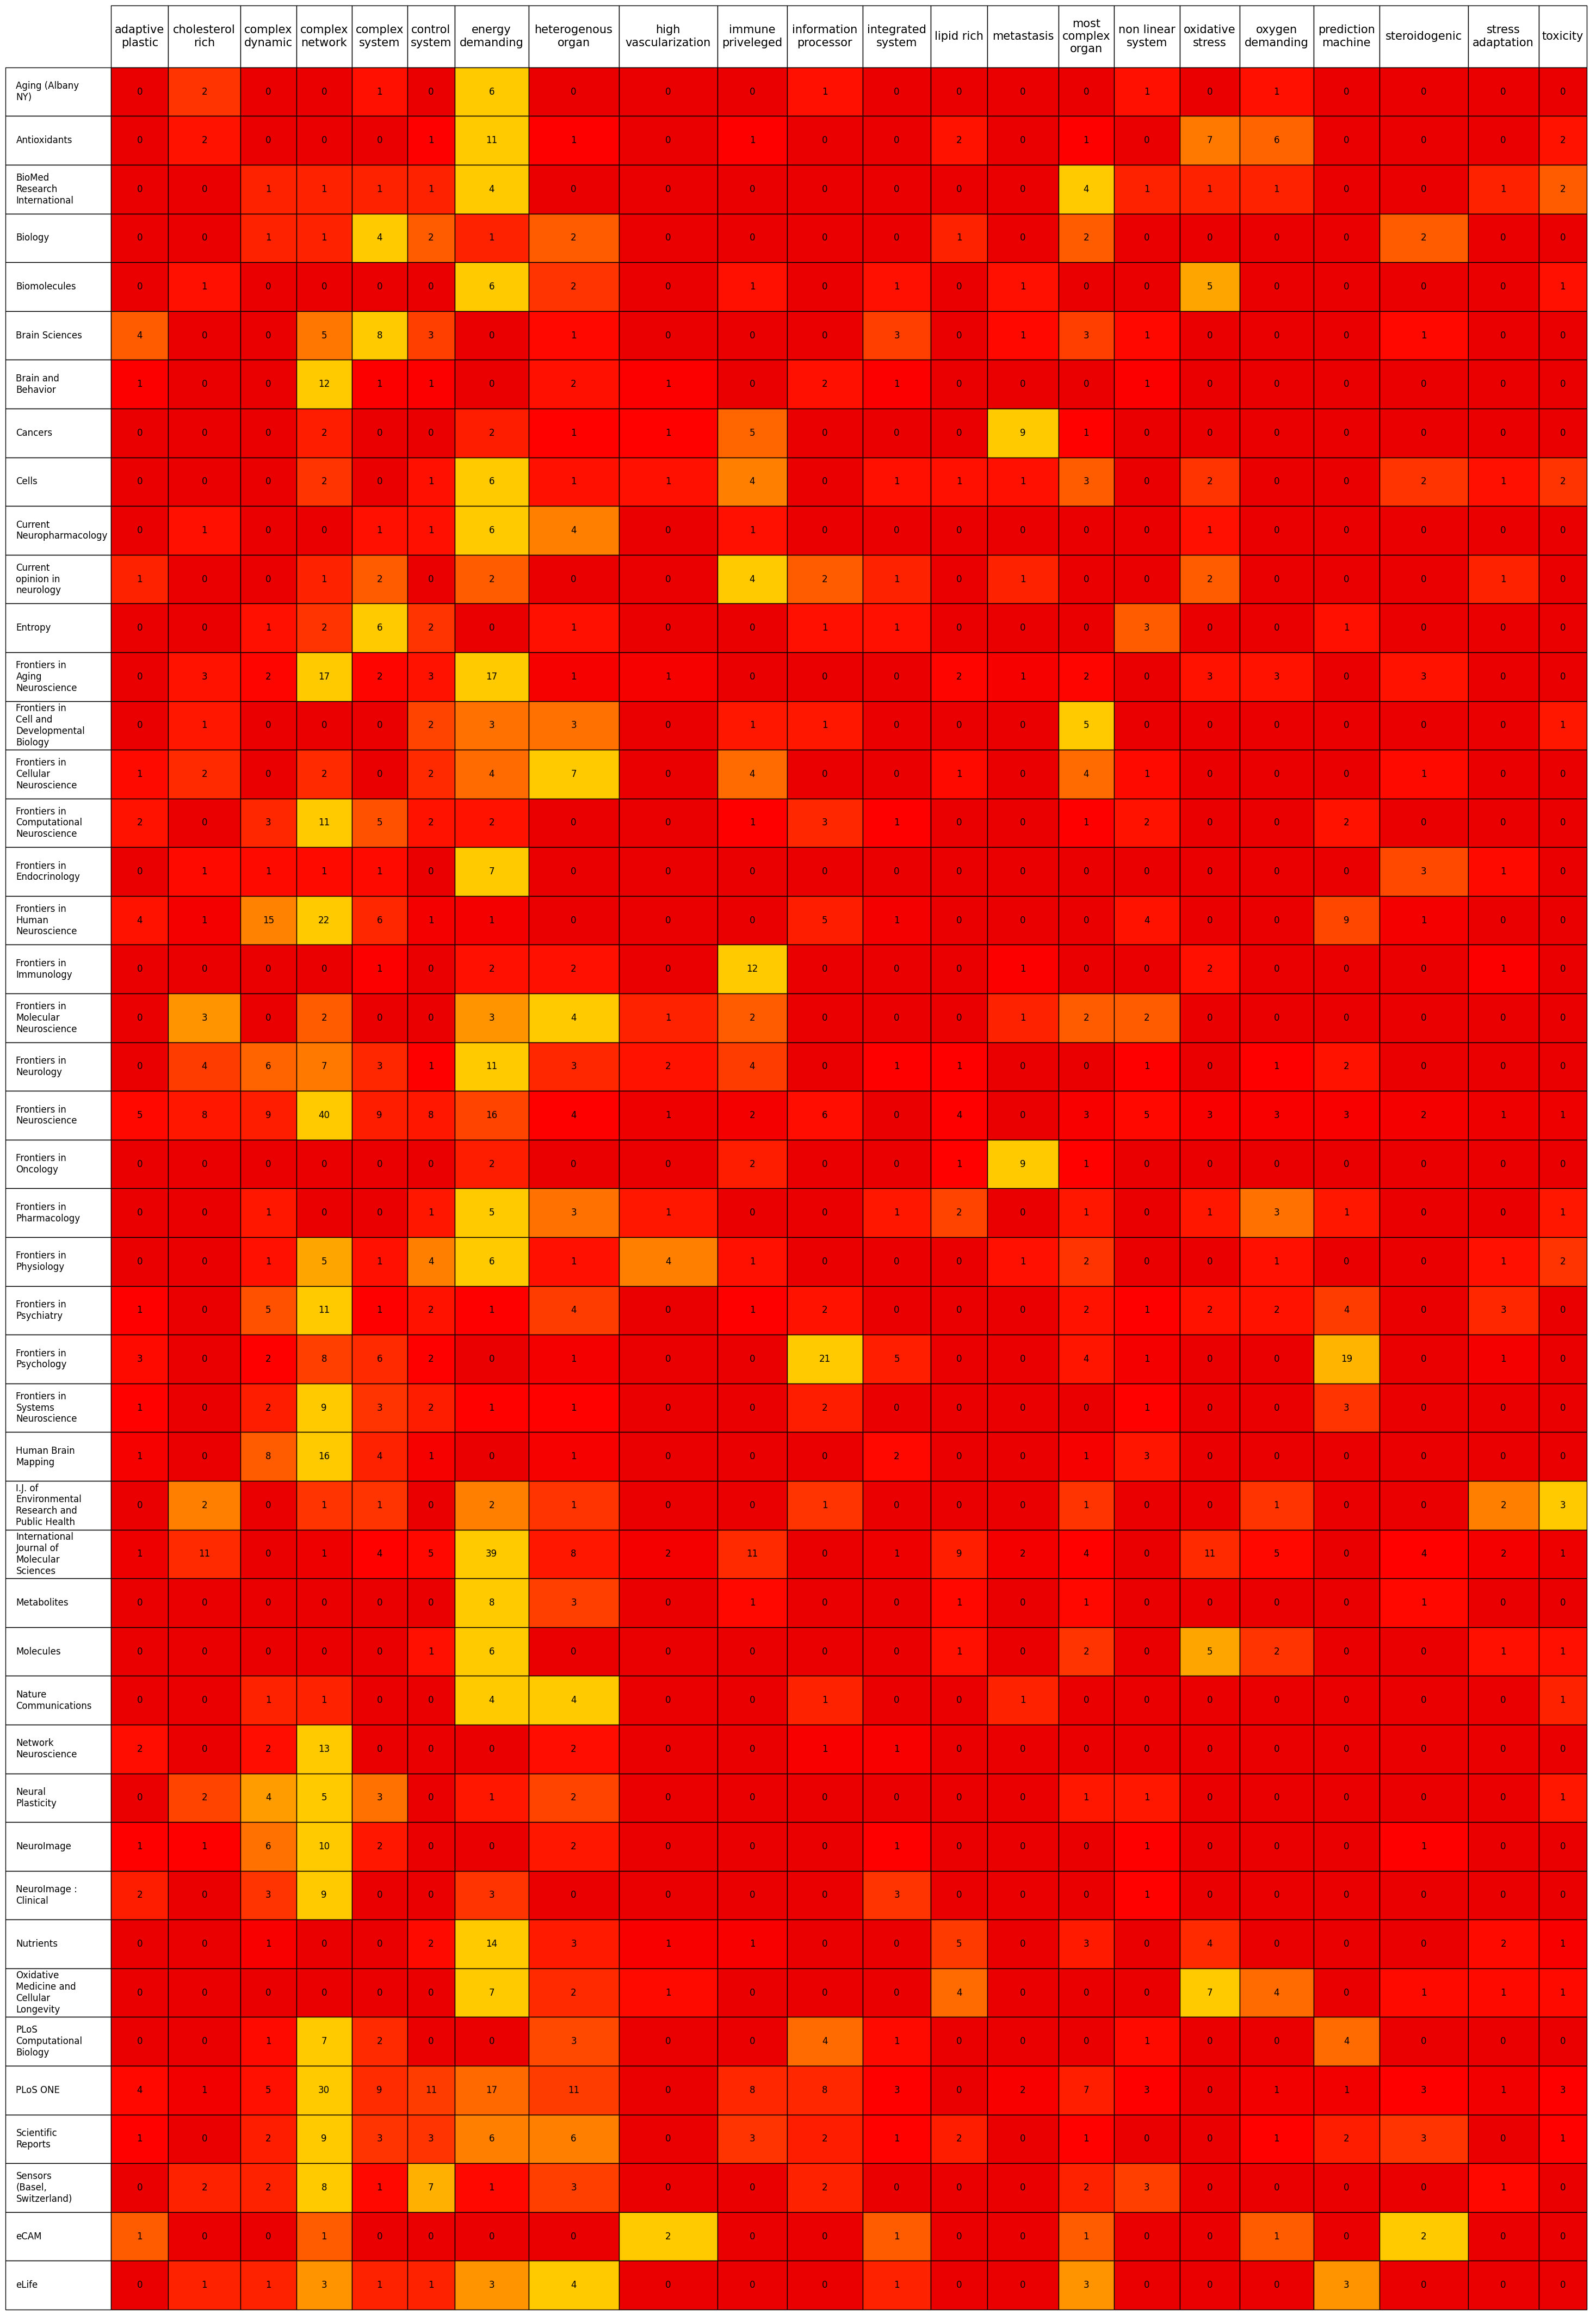

In [125]:
cj_ct_norm=cj_ct.sub(cj_ct.min(axis=1), axis=0).div((cj_ct.max(axis=1)-cj_ct.min(axis=1)), axis=0)

norm = plt.Normalize(cj_ct_norm.values.min()-1, cj_ct_norm.values.max()+1)
colours = plt.cm.hot(norm(cj_ct_norm.values))

fig, ax = plt.subplots(figsize=(35,55))
ax.axis('off')

# create new lines to fit text labels in cells
wrapper = textwrap.TextWrapper(width=14, break_long_words=False)
j_newline = [wrapper.fill(text=j) for j in cj_ct.index]
c_newline = [c.replace('-', '\n').replace('_', '\n') for c in cj_ct.columns]


table = ax.table(
    cellText=cj_ct.values, rowLabels=j_newline, 
    colLabels=c_newline, colWidths = [0.01]*cj_ct.shape[1], 
    cellColours=colours, cellLoc='center', bbox=[0, 0, 1, 1]
)

table.auto_set_font_size(False)
table.set_fontsize(12)
# table.scale(2, 2)

cells = table._cells
for cell in table._cells:
    if cell[0] == 0:
        table._cells[cell].set_fontsize(15)
        table._cells[cell].set_height(0.005)
    elif cell[1] == -1:
        table._cells[cell].set_fontsize(12)
        
table.auto_set_column_width(col=list(range(len(cj_ct.columns))))
plt.show()


## 4.4 Article Sections

In [12]:
section_label = []
for id in articles:
    a = articles[id]
    if 'text' in a:
        for t in a['text']:
            if any([s in a['text'][t] for s in a['matched_sent']]):
                section_label.append(t.strip().lower())
    else:
        section_label.append('abstract')


section_label = [re.sub("[0-9,.:;?!\"' ]",'', s) for s in section_label]
standard_sections = ['result', 'introduction', 'method', 'materials', 'discussion', 
                     'conclusion' ,'background']
section_label_standard = [
    s for s in section_label 
    if any([std in s for std in standard_sections])
]

In [15]:
pd.Series(section_label).value_counts(normalize=True)

introduction                                0.324144
discussion                                  0.133012
abstract                                    0.096715
                                            0.032391
background                                  0.022283
                                              ...   
enzymereplacementtherapy(ert)               0.000230
alteredfunctionalconnectivitybetweenrsns    0.000230
functionalconnectivityanalyses              0.000230
temozolomide                                0.000230
definitionofdeath                           0.000230
Name: proportion, Length: 1610, dtype: float64